Sometimes Product Owner have to choose between two KPIs of his product and invest money in one of possible directions. For example - traffic attraction or conversion optimization. These are two strategies and his backlog have to be prioritized right now. Here we use ML scores as a measure of KPI selection. In fact we look how this or that KPI helps to predict possible cash flow. In this example we have one product with fixed price. We use web site metrics to understand what strategy should be chosen - attraction or activation, ads  or CRO. I show that standard statistical measures like correlation fail and nonlinear ML models give insight. It works on relatively small data due to ensemble voting - diversification of models is involved. 

Ignore warnings

In [214]:
import warnings
warnings.filterwarnings("ignore")

Define general parameters

In [215]:
split_num=10 #number of cross validation intervals
out_sample=0.5 #out-of-sample split
neigbors_maximum=10 #max number of neighbors for KNN
boundary=0.4 #boundary for Offers classification

In [2]:
Import general libraries: arrays,dateframe

In [216]:
import numpy as np #work with arrays
import pandas as pd #work with dateframe
from pandas import set_option
import matplotlib.pyplot as plt #work with charts
import seaborn as sns #work with color charts 

Import statistical libraries

In [217]:
from scipy.stats.stats import pearsonr #correlation method
from statistics import median #median search

Import ML libraries for out-of-sample tests and hyperparameter tuning

In [218]:
from sklearn.model_selection import train_test_split #standard out-of-sample test
from sklearn.model_selection import cross_val_score #cross validation test
from sklearn.model_selection import GridSearchCV #hyperperameter tuning
from sklearn.model_selection import KFold #sample split

Principle component analysis library

In [219]:
from sklearn.decomposition import PCA

Ridge-regression for regression with regularisation

In [220]:
from sklearn.linear_model import Ridge

Binary classifiers

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

Feature selection library

In [222]:
from sklearn.ensemble import ExtraTreesClassifier

Custom functions - standartization to (0,1) interval

In [223]:
def standart(x):
    max_value=x.max();
    min_value=x.min()
    z=(x-min_value) / (max_value - min_value)
    return z

Custom functions - correlation map

In [224]:
def cormap(x):
  corr=x.corr();fig=plt.figure(figsize=(10, 7))
  g=sns.heatmap(corr,annot=True,linewidths=.2, cbar_kws={"orientation": "horizontal"})
  plt.show()

Custom functions - Person coefficient output

In [225]:
def cf(x,y):
  CFV=pearsonr(x,y);correlation=str(abs(round(int(100*CFV[0]))))
  p_mystake=str(round((100*CFV[1]),3));cf_mst=[correlation,p_mystake]
  return cf_mst

Custom functions - exploratory analysis

In [226]:
def eda(x):
  pd.plotting.scatter_matrix(x,figsize=[8,8],diagonal='kde',grid=True,ax=None,range_padding=1)
  plt.show()

Classification of continuous var by median

In [227]:
def get_class(x):
  #threshold=median(list(x))
  threshold=boundary
  class_type=[]
  for item in list(x):
    if item>=threshold: label=1;class_type.append(label)
    if item<threshold: label=0;class_type.append(label)
  return class_type  

Custom function - plot PCA components and make an output

In [228]:
def pca(x,y):
  pca=PCA()
  pca.fit(y) 
  PCA(copy=True)
  features=x
  pca.explained_variance_=standart(pca.explained_variance_)
  pca.explained_variance_=list(np.array(pca.explained_variance_)*100)
  plt.bar(x, pca.explained_variance_,width=0.5)
  plt.xticks(features);plt.ylabel('variance');plt.xlabel('PCA feature')
  print('Input of component - PCA:')
  for i in range(0,len(pca.explained_variance_)):
    print(str(x[i])+': '+str(int(pca.explained_variance_[i]))+'%')
    i=i+1
  plt.show()

Read data from xls file: Date of record,Number of sessions,Unique Users,Number of content view,Av. bounce rate,Number of pages loaded,Time of session,Commercial Offers from CRM in the considered daily period. Daily discretization, 3 years.

In [229]:
path='web_crm.xlsx'
df=pd.read_excel(path)

Show column names

In [230]:
column_names=list(df.columns.values)
print('All fields:',column_names)

All fields: ['Date', 'Visits', 'Viewers', 'Views', 'BR', 'Depth', 'Time', 'Offers']


Show time interval:

In [231]:
print('Data Start:',list(df['Date'])[0])
print('Data End:',list(df['Date'])[-1])

Data Start: 2016-05-09
Data End: 2019-05-07


Show number of records - small data

In [232]:
print('Number of records:', len(df))

Number of records: 1092


Standartize features to avoid ML unstability

In [233]:
df['Visits']=standart(df['Visits'])
df['Viewers']=standart(df['Viewers'])
df['Views']=standart(df['Views'])
df['BR']=standart(df['BR'])
df['Depth']=standart(df['Depth'])
df['Time']=standart(df['Time'])
df['Offers']=standart(df['Offers'])

Remove date feature

In [234]:
del df['Date']

Make correlation map

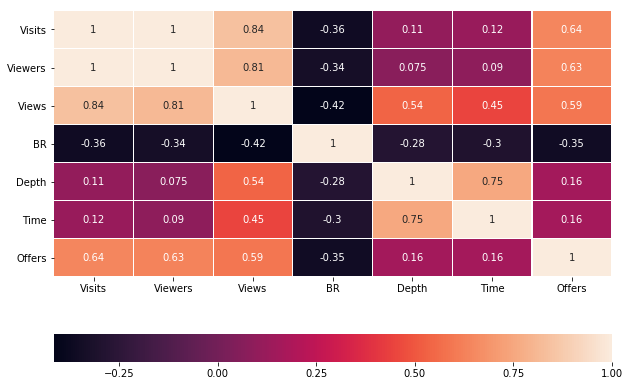

In [235]:
cormap(df)

We can guess that number of sessions (Visits) and Unique Visitors (Viewers) and Views may be good features - traffic 

Let's validate this by EDA visualization chart

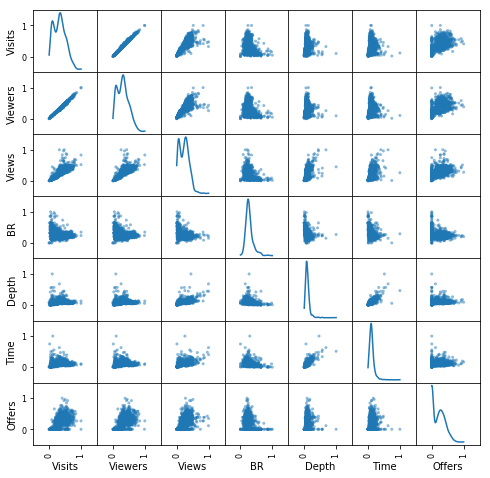

In [236]:
eda(df)

Not brilliant regression however for Offers. However we notice that visits and viewers have good correlation and regression. It's linear approach, supposing normal distribution of residuals. Ok, let's analyze feature input by PCA.

Input of component - PCA:
Visits: 100%
Viewers: 16%
Views: 14%
BR: 9%
Depth: 1%
Time: 0%
Offers: 0%


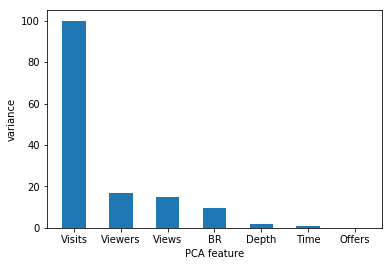

In [237]:
column_names=df.columns
pca(column_names,df)

Number of sessions is in top. However PCA suggests to add bounce rate. Befor we get EDA for Offers distribution. 

Offers:
count    1092.000
mean        0.208
std         0.196
min         0.000
25%         0.000
50%         0.192
75%         0.346
max         1.000
Name: Offers, dtype: float64


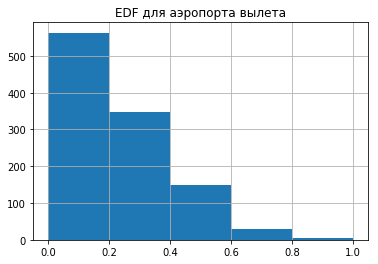

In [238]:
set_option('display.width',100)
set_option('precision',3)

print('Offers:')
description=df['Offers'].describe()
print(description)

df['Offers'].hist(bins=5)
plt.title('EDF для аэропорта вылета')
plt.show()

We can see that greatest part of distribution is actually between 0 and mean+std, 0 and 0.4. So we can choose 0.4-0.6 (2 sigma) as a theshold for binary classification

We add binary Offers to the table. We can just split all values by boundary of 0.4

In [239]:
df_binary=df.copy()
df_binary['Offers_binary']=get_class(df_binary['Offers'])

In [ ]:
Let's split 4 features from target.

In [240]:
array_df=df_binary.values
X=array_df[:,0:4];Y=array_df[:,7]

Estimation of feature importance based on tree classifier. 

In [241]:
model=ExtraTreesClassifier(n_estimators=100)
model.fit(X, Y)
print('Feature importance [Visits],[Viewers],[Views],[BR]:',model.feature_importances_)

Feature importance [Visits],[Viewers],[Views],[BR]: [0.24851838 0.23974185 0.27499167 0.2367481 ]


We can see that all features gives the same output. Ok, finally let's validate Offers (continuous var) prediction through these features by Ridge regression.

In [242]:
array_reg=df.values
X_reg=array_reg[:,0:4];Y_reg=array_reg[:,6]
kfold=KFold(n_splits=split_num, random_state=7);model=Ridge()
results=cross_val_score(model, X_reg, Y_reg, cv=kfold, scoring='r2')
print('Mean R2 for Ridge Regression:',round(results.mean(),2))
print('Deviation of R2 for Ridge Linear Regression:',round(results.std(),2))

X_train,X_test,Y_train,Y_test=train_test_split(X_reg,Y_reg,test_size=0.8)
model=Ridge();model.fit(X_train,Y_train)
score_dt=model.score(X_test,Y_test)
print('Accuracy for out of sample test 50/50='+str(round((100*score_dt),3))+'%')

Mean R2 for Ridge Regression: 0.42
Deviation of R2 for Ridge Linear Regression: 0.07
Accuracy for out of sample test 50/50=43.08%


Poor result for R2 - we need nonlinear algorithms of ML - Naive Bayes,KNN,DecisionTreeClassifier

In [ ]:
Let's make an ensemble of classificators for binary table

In [243]:
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ansamble:'+str(100*round((results.mean()),3))+'%')
print('Deviation of validation score:'+str(100*round((results.std()),3))+'%')

Average score of validation for ansamble:80.2%
Deviation of validation score:5.2%


Great! Deviation less than 6%. What if we remove bounce rate and views and leave pure traffic metrics - number of sessions and visitors. Although they perfectly correlate.

In [244]:
X=array_df[:,0:1]
estimators = []
a=KNeighborsClassifier(n_neighbors=neigbors_maximum)
b=GaussianNB()
c=DecisionTreeClassifier(criterion='entropy')

estimators.append(('knn',a))
estimators.append(('naive', b))
estimators.append(('dt', c))

ensemble = VotingClassifier(estimators)
results = cross_val_score(ensemble, X, Y, cv=kfold)
print('Average score of validation for ansamble:'+str(100*round((results.mean()),3))+'%')
print('Deviation of validation score:'+str(100*round((results.std()),3))+'%')

Average score of validation for ansamble:82.8%
Deviation of validation score:6.2%


Less features - less overfit risk. So, finally we have two metrics, which predicts binary function of offers number with accuracy of 83% and deviation of 6%. However not accuracy, but factor analysis is essential. PCA, EDA, Tree Classifier show that traffic features determine conversion into the commercial offer. PO may focus on traffic attraction more than web CRO.   